# Handwritten Digit Recognition
- Author = Abdelrahman Mohamed
- Dataset = MNIST
- [Article Link](https://blog.machinfy.com/wp-admin/post.php?post=311)
- Frameworks = PyTorch

### Necessary Imports

In [1]:
#Scientific computing 
import numpy as np

#Pytorch packages
import torch
from torch import nn
import torch.optim as optim
import torchvision

#Visulization
import matplotlib.pyplot as plt

#Others
import time
import copy

### Download The Dataset & Define The Transforms

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

class_names = trainset.classes
dataset_sizes = {'train':len(trainset), 'val':len(valset)}
dataloaders  = {'train':trainloader, 'val':valloader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Exploring The Data

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


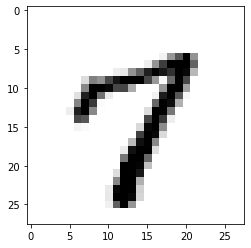

In [4]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

### Defining The Neural Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
        )
    
    
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
        )
        
          

        self.fcs = nn.Sequential(
            nn.Linear(2304, 1152),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1152, 576),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(576, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x
               

In [6]:
model = Net()
model

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False

In [7]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

### Train and evaluate

In [8]:
def train_model(model, criterion, optimizer, scheduler, dataset_sizes, dataloaders, num_epochs=25 ):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,dataset_sizes,dataloaders,num_epochs=7)

Epoch 0/6
----------
train Loss: 0.1965 Acc: 0.9392
val Loss: 0.0737 Acc: 0.9787

Epoch 1/6
----------
train Loss: 0.0763 Acc: 0.9788
val Loss: 0.0417 Acc: 0.9881

Epoch 2/6
----------
train Loss: 0.0564 Acc: 0.9849
val Loss: 0.0344 Acc: 0.9901

Epoch 3/6
----------
train Loss: 0.0480 Acc: 0.9880
val Loss: 0.0244 Acc: 0.9918

Epoch 4/6
----------
train Loss: 0.0406 Acc: 0.9890
val Loss: 0.0369 Acc: 0.9902

Epoch 5/6
----------
train Loss: 0.0370 Acc: 0.9904
val Loss: 0.0278 Acc: 0.9927

Epoch 6/6
----------
train Loss: 0.0301 Acc: 0.9917
val Loss: 0.0220 Acc: 0.9935

Training complete in 2m 56s
Best val Acc: 0.993500


## Visualizing the model predictions

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().squeeze()
    plt.imshow(inp, cmap='gray_r')
    if title is not None:
        plt.title(title)

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
        model.train(mode=was_training)


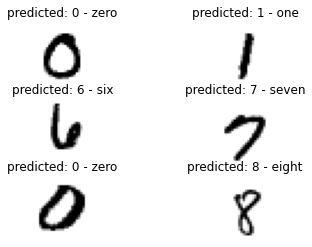

In [12]:
visualize_model(model)

In [13]:
torch.save(model, './my_mnist_model.pt') 